In [1]:
import detectron2
import torch
import copy
import pickle 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import detection_utils as utils 
from detectron2.data.detection_utils import annotations_to_instances

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for the mapepr
import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch

from detectron2.config import configurable

from detectron2.data import detection_utils as utils 
import detectron2.data.transforms as T

In [3]:
torch.__version__

'1.10.0'

In [4]:
!nvidia-smi

Fri Jan 20 10:05:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   55C    P0    87W / 300W |  23406MiB / 32768MiB |     87%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

# Register the dataset so that it can be used by dataloader

In [5]:
def get_detectron_train_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/DetectronData/"
    xml_files = [
        "327_A1d_ASAP.xml",
        "270_A1d_ASAP.xml",
        "131_B1e_ASAP_fixed.xml", 
        "41_A2c_ASAP_fixed.xml", 
        "51_D1b_ASAP_fixed.xml"
        
    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [6]:
def get_detectron_test_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/DetectronData/"
    xml_files = [
        "281_A1f_ASAP.xml",

    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [7]:
train_data = get_detectron_train_data()
test_data = get_detectron_test_data()

In [8]:
# new_data = test_data[15:]
# print(len(new_data))
# test_data = test_data[:15]
# for d in new_data:
#     train_data.append(d)

In [9]:
print(len(train_data), len(test_data))

1173 115


In [10]:
DatasetCatalog.register("nuclei_detection_train", get_detectron_train_data)
DatasetCatalog.register("nuclei_detection_test", get_detectron_test_data)

In [11]:
MetadataCatalog.get("nuclei_detection_train").thing_classes = ["cell"] 
MetadataCatalog.get("nuclei_detection_test").thing_classes = ["cell"] 

In [12]:
mapper = DatasetMapper(is_train=True,
                         augmentations=[T.Resize((128, 128))], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR")

In [13]:
mapper(train_data[0])

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/Images/327_A1d_ASAP_0.jpg',
 'height': 128,
 'width': 128,
 'image_id': '327_A1d_ASAP_0',
 'image': tensor([[[223, 217, 224,  ..., 185, 178, 159],
          [213, 219, 226,  ..., 188, 168, 150],
          [207, 224, 225,  ..., 185, 147, 132],
          ...,
          [222, 221, 219,  ..., 202, 217, 203],
          [213, 211, 210,  ..., 191, 202, 185],
          [221, 214, 208,  ..., 172, 188, 184]],
 
         [[189, 184, 189,  ..., 135, 124, 103],
          [179, 186, 191,  ..., 138, 114,  94],
          [173, 188, 188,  ..., 137,  95,  78],
          ...,
          [195, 194, 192,  ..., 156, 171, 157],
          [186, 184, 183,  ..., 145, 156, 139],
          [194, 187, 181,  ..., 126, 142, 138]],
 
         [[226, 219, 223,  ..., 165, 153, 132],
          [216, 221, 225,  ..., 168, 144, 123],
          [210, 224, 222,  ..., 166, 125, 107],
  

In [14]:
# we create the train dataloader here. Might make sense to play around with batch_size.
train_dataloader = build_detection_train_loader(
    train_data,
    mapper=DatasetMapper(is_train=True,
                         augmentations=[T.Resize((128, 128))], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    total_batch_size = 1, 
    )

In [15]:
test_dataloader = build_detection_test_loader(
    test_data,
    mapper=DatasetMapper(is_train=True,
                         augmentations=[], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    )

In [16]:
data = None
for x in train_dataloader:
    print(x[0]["instances"])
    data = x
    break

Instances(num_instances=15, image_height=128, image_width=128, fields=[gt_boxes: Boxes(tensor([[1.5490e+01, 1.0735e+02, 2.9625e+01, 1.2252e+02],
        [2.2891e+00, 1.0028e+02, 1.0502e+01, 1.1036e+02],
        [1.0606e+01, 9.1967e+01, 1.7258e+01, 1.0226e+02],
        [2.9105e+01, 8.8537e+01, 4.5217e+01, 1.0371e+02],
        [1.5490e+01, 8.2508e+01, 2.4324e+01, 8.9264e+01],
        [2.0688e+01, 6.3383e+01, 3.1185e+01, 7.9701e+01],
        [3.8564e+01, 5.2158e+01, 4.9479e+01, 6.2654e+01],
        [3.1912e+01, 5.5588e+01, 3.7836e+01, 6.1199e+01],
        [1.2275e+02, 1.1171e+02, 1.2743e+02, 1.1889e+02],
        [6.2527e+01, 1.2207e+01, 7.9104e+01, 2.6242e+01],
        [8.2969e+01, 1.5869e+01, 9.3646e+01, 2.3801e+01],
        [1.0341e+02, 3.9000e-03, 1.1561e+02, 9.0547e+00],
        [2.1758e+00, 5.8826e+01, 1.4650e+01, 7.2936e+01],
        [2.3441e+01, 1.5479e+01, 3.5711e+01, 2.4373e+01],
        [3.1928e+01, 1.9465e+01, 5.4930e+01, 3.8584e+01]])), gt_classes: tensor([0, 0, 0, 0, 0, 0, 0,

# Visualize Training Data

In [17]:
from detectron2.utils.visualizer import ColorMode, Visualizer
data

[{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/Images/131_B1e_ASAP_fixed_693.jpg',
  'height': 128,
  'width': 128,
  'image_id': '131_B1e_ASAP_fixed_693',
  'image': tensor([[[230, 235, 247,  ..., 232, 213, 183],
           [229, 228, 237,  ..., 237, 217, 206],
           [226, 222, 230,  ..., 231, 216, 222],
           ...,
           [184, 228, 222,  ..., 195, 194, 204],
           [229, 248, 221,  ..., 207, 200, 213],
           [196, 186, 163,  ..., 211, 200, 219]],
  
          [[227, 228, 240,  ..., 192, 181, 161],
           [219, 223, 235,  ..., 200, 186, 186],
           [213, 216, 229,  ..., 198, 187, 201],
           ...,
           [123, 169, 166,  ..., 159, 167, 190],
           [163, 188, 164,  ..., 169, 168, 189],
           [127, 126, 110,  ..., 167, 154, 178]],
  
          [[236, 235, 245,  ..., 240, 235, 219],
           [231, 232, 241,  ..., 240, 231, 233],
           [

In [18]:
data[0]

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/Images/131_B1e_ASAP_fixed_693.jpg',
 'height': 128,
 'width': 128,
 'image_id': '131_B1e_ASAP_fixed_693',
 'image': tensor([[[230, 235, 247,  ..., 232, 213, 183],
          [229, 228, 237,  ..., 237, 217, 206],
          [226, 222, 230,  ..., 231, 216, 222],
          ...,
          [184, 228, 222,  ..., 195, 194, 204],
          [229, 248, 221,  ..., 207, 200, 213],
          [196, 186, 163,  ..., 211, 200, 219]],
 
         [[227, 228, 240,  ..., 192, 181, 161],
          [219, 223, 235,  ..., 200, 186, 186],
          [213, 216, 229,  ..., 198, 187, 201],
          ...,
          [123, 169, 166,  ..., 159, 167, 190],
          [163, 188, 164,  ..., 169, 168, 189],
          [127, 126, 110,  ..., 167, 154, 178]],
 
         [[236, 235, 245,  ..., 240, 235, 219],
          [231, 232, 241,  ..., 240, 231, 233],
          [227, 227, 238,  ..., 23

In [19]:
data[0]["instances"].gt_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
data[0]["image"].shape

torch.Size([3, 128, 128])

In [21]:
img = cv2.imread(data[0]["file_name"])

In [22]:
v = Visualizer(img)

In [23]:
v = v.overlay_instances(boxes=data[0]["instances"].gt_boxes, labels=data[0]["instances"].gt_classes.numpy(), masks=data[0]["instances"].gt_masks)

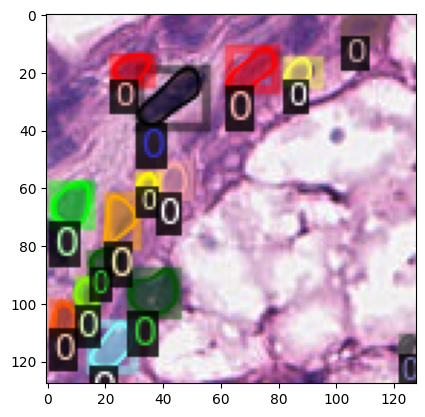

In [24]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

# Training the Segmentation Model

In [58]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg

In [62]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = "nuclei_detection_train"
cfg.DATASETS.TEST = "nuclei_detection_test"
cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32  # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.BASE_LR = 5e-5
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [63]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[01/20 10:42:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/20 10:43:28 d2.data.build]: Removed 0 images with no usable annotations. 1173 images left.
[01/20 10:43:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/20 10:43:28 d2.data.build]: Using training sampler TrainingSampler
[01/20 10:43:28 d2.data.common]: Serializing 1173 elements to byte tensors and concatenating them all ...
[01/20 10:44:17 d2.data.common]: Serialized dataset takes 586.34 MiB
WARNING [01/20 10:44:18 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [64]:
trainer.train()

[01/20 10:44:18 d2.engine.train_loop]: Starting training from iteration 0
[01/20 10:44:24 d2.utils.events]:  eta: 0:31:50  iter: 19  total_loss: 3.001  loss_cls: 0.7331  loss_box_reg: 0.8252  loss_mask: 0.6887  loss_rpn_cls: 0.6774  loss_rpn_loc: 0.09848  time: 0.2118  data_time: 0.0749  lr: 9.9905e-07  max_mem: 2545M
[01/20 10:44:28 d2.utils.events]:  eta: 0:33:05  iter: 39  total_loss: 3.047  loss_cls: 0.7349  loss_box_reg: 0.7832  loss_mask: 0.6879  loss_rpn_cls: 0.7825  loss_rpn_loc: 0.08946  time: 0.2148  data_time: 0.0090  lr: 1.998e-06  max_mem: 2545M
[01/20 10:44:33 d2.utils.events]:  eta: 0:33:55  iter: 59  total_loss: 2.516  loss_cls: 0.7135  loss_box_reg: 0.7552  loss_mask: 0.6851  loss_rpn_cls: 0.2736  loss_rpn_loc: 0.04666  time: 0.2188  data_time: 0.0092  lr: 2.997e-06  max_mem: 2545M
[01/20 10:44:37 d2.utils.events]:  eta: 0:33:26  iter: 79  total_loss: 2.855  loss_cls: 0.697  loss_box_reg: 0.7714  loss_mask: 0.6826  loss_rpn_cls: 0.5468  loss_rpn_loc: 0.1133  time: 0.21

[01/20 10:46:50 d2.utils.events]:  eta: 0:31:38  iter: 679  total_loss: 1.731  loss_cls: 0.3815  loss_box_reg: 0.815  loss_mask: 0.3925  loss_rpn_cls: 0.05052  loss_rpn_loc: 0.05265  time: 0.2188  data_time: 0.0083  lr: 3.3966e-05  max_mem: 2545M
[01/20 10:46:54 d2.utils.events]:  eta: 0:31:34  iter: 699  total_loss: 1.761  loss_cls: 0.3989  loss_box_reg: 0.8049  loss_mask: 0.395  loss_rpn_cls: 0.07828  loss_rpn_loc: 0.07253  time: 0.2186  data_time: 0.0082  lr: 3.4965e-05  max_mem: 2545M
[01/20 10:46:58 d2.utils.events]:  eta: 0:31:19  iter: 719  total_loss: 1.603  loss_cls: 0.3576  loss_box_reg: 0.733  loss_mask: 0.3955  loss_rpn_cls: 0.06218  loss_rpn_loc: 0.03477  time: 0.2172  data_time: 0.0190  lr: 3.5964e-05  max_mem: 2545M
[01/20 10:47:01 d2.utils.events]:  eta: 0:30:58  iter: 739  total_loss: 1.714  loss_cls: 0.4028  loss_box_reg: 0.7644  loss_mask: 0.3923  loss_rpn_cls: 0.06338  loss_rpn_loc: 0.07536  time: 0.2161  data_time: 0.0443  lr: 3.6963e-05  max_mem: 2545M
[01/20 10:4

[01/20 10:49:23 d2.utils.events]:  eta: 0:27:41  iter: 1359  total_loss: 1.393  loss_cls: 0.3497  loss_box_reg: 0.5604  loss_mask: 0.3253  loss_rpn_cls: 0.04076  loss_rpn_loc: 0.06055  time: 0.2105  data_time: 0.0091  lr: 5e-05  max_mem: 2545M
[01/20 10:49:27 d2.utils.events]:  eta: 0:27:38  iter: 1379  total_loss: 1.31  loss_cls: 0.3185  loss_box_reg: 0.558  loss_mask: 0.3256  loss_rpn_cls: 0.03318  loss_rpn_loc: 0.05726  time: 0.2107  data_time: 0.0173  lr: 5e-05  max_mem: 2545M
[01/20 10:49:31 d2.utils.events]:  eta: 0:27:38  iter: 1399  total_loss: 1.276  loss_cls: 0.3038  loss_box_reg: 0.5587  loss_mask: 0.3245  loss_rpn_cls: 0.04082  loss_rpn_loc: 0.04286  time: 0.2107  data_time: 0.0112  lr: 5e-05  max_mem: 2545M
[01/20 10:49:36 d2.utils.events]:  eta: 0:27:32  iter: 1419  total_loss: 1.298  loss_cls: 0.3654  loss_box_reg: 0.5574  loss_mask: 0.3198  loss_rpn_cls: 0.05191  loss_rpn_loc: 0.04532  time: 0.2108  data_time: 0.0090  lr: 5e-05  max_mem: 2545M
[01/20 10:49:40 d2.utils.e

[01/20 10:51:53 d2.utils.events]:  eta: 0:27:17  iter: 2039  total_loss: 1.286  loss_cls: 0.3443  loss_box_reg: 0.567  loss_mask: 0.3133  loss_rpn_cls: 0.02889  loss_rpn_loc: 0.03958  time: 0.2131  data_time: 0.0090  lr: 5e-05  max_mem: 2545M
[01/20 10:51:57 d2.utils.events]:  eta: 0:27:14  iter: 2059  total_loss: 1.325  loss_cls: 0.3201  loss_box_reg: 0.566  loss_mask: 0.337  loss_rpn_cls: 0.04136  loss_rpn_loc: 0.07295  time: 0.2133  data_time: 0.0110  lr: 5e-05  max_mem: 2545M
[01/20 10:52:02 d2.utils.events]:  eta: 0:27:10  iter: 2079  total_loss: 1.29  loss_cls: 0.3139  loss_box_reg: 0.551  loss_mask: 0.3102  loss_rpn_cls: 0.04038  loss_rpn_loc: 0.07743  time: 0.2134  data_time: 0.0110  lr: 5e-05  max_mem: 2545M
[01/20 10:52:06 d2.utils.events]:  eta: 0:27:05  iter: 2099  total_loss: 1.177  loss_cls: 0.3009  loss_box_reg: 0.4882  loss_mask: 0.2793  loss_rpn_cls: 0.02888  loss_rpn_loc: 0.04254  time: 0.2133  data_time: 0.0095  lr: 5e-05  max_mem: 2545M
[01/20 10:52:11 d2.utils.even

[01/20 10:54:28 d2.utils.events]:  eta: 0:23:41  iter: 2719  total_loss: 1.413  loss_cls: 0.3743  loss_box_reg: 0.5868  loss_mask: 0.3435  loss_rpn_cls: 0.02708  loss_rpn_loc: 0.04303  time: 0.2117  data_time: 0.0102  lr: 5e-05  max_mem: 2545M
[01/20 10:54:32 d2.utils.events]:  eta: 0:23:34  iter: 2739  total_loss: 1.331  loss_cls: 0.3224  loss_box_reg: 0.536  loss_mask: 0.3397  loss_rpn_cls: 0.02638  loss_rpn_loc: 0.05829  time: 0.2118  data_time: 0.0106  lr: 5e-05  max_mem: 2545M
[01/20 10:54:37 d2.utils.events]:  eta: 0:23:24  iter: 2759  total_loss: 1.437  loss_cls: 0.3097  loss_box_reg: 0.5787  loss_mask: 0.3266  loss_rpn_cls: 0.0302  loss_rpn_loc: 0.04774  time: 0.2118  data_time: 0.0093  lr: 5e-05  max_mem: 2545M
[01/20 10:54:41 d2.utils.events]:  eta: 0:23:20  iter: 2779  total_loss: 1.327  loss_cls: 0.3149  loss_box_reg: 0.5511  loss_mask: 0.3429  loss_rpn_cls: 0.02568  loss_rpn_loc: 0.0386  time: 0.2119  data_time: 0.0102  lr: 5e-05  max_mem: 2545M
[01/20 10:54:45 d2.utils.ev

[01/20 10:57:01 d2.utils.events]:  eta: 0:22:39  iter: 3399  total_loss: 1.248  loss_cls: 0.3256  loss_box_reg: 0.5056  loss_mask: 0.3236  loss_rpn_cls: 0.03528  loss_rpn_loc: 0.04883  time: 0.2139  data_time: 0.0090  lr: 5e-05  max_mem: 2545M
[01/20 10:57:05 d2.utils.events]:  eta: 0:22:36  iter: 3419  total_loss: 1.275  loss_cls: 0.3386  loss_box_reg: 0.5094  loss_mask: 0.2967  loss_rpn_cls: 0.03716  loss_rpn_loc: 0.06428  time: 0.2139  data_time: 0.0085  lr: 5e-05  max_mem: 2545M
[01/20 10:57:10 d2.utils.events]:  eta: 0:22:30  iter: 3439  total_loss: 1.236  loss_cls: 0.3331  loss_box_reg: 0.5319  loss_mask: 0.3183  loss_rpn_cls: 0.02924  loss_rpn_loc: 0.04827  time: 0.2139  data_time: 0.0089  lr: 5e-05  max_mem: 2545M
[01/20 10:57:14 d2.utils.events]:  eta: 0:22:21  iter: 3459  total_loss: 1.3  loss_cls: 0.3384  loss_box_reg: 0.5165  loss_mask: 0.3154  loss_rpn_cls: 0.035  loss_rpn_loc: 0.05889  time: 0.2139  data_time: 0.0090  lr: 5e-05  max_mem: 2545M
[01/20 10:57:18 d2.utils.eve

[01/20 10:59:38 d2.utils.events]:  eta: 0:19:08  iter: 4079  total_loss: 1.29  loss_cls: 0.2977  loss_box_reg: 0.5471  loss_mask: 0.3146  loss_rpn_cls: 0.03475  loss_rpn_loc: 0.0591  time: 0.2130  data_time: 0.0099  lr: 5e-05  max_mem: 2545M
[01/20 10:59:43 d2.utils.events]:  eta: 0:19:06  iter: 4099  total_loss: 1.397  loss_cls: 0.3568  loss_box_reg: 0.5483  loss_mask: 0.3333  loss_rpn_cls: 0.0316  loss_rpn_loc: 0.05087  time: 0.2131  data_time: 0.0140  lr: 5e-05  max_mem: 2545M
[01/20 10:59:48 d2.utils.events]:  eta: 0:19:02  iter: 4119  total_loss: 1.353  loss_cls: 0.3742  loss_box_reg: 0.5538  loss_mask: 0.312  loss_rpn_cls: 0.04385  loss_rpn_loc: 0.0547  time: 0.2131  data_time: 0.0088  lr: 5e-05  max_mem: 2545M
[01/20 10:59:52 d2.utils.events]:  eta: 0:18:58  iter: 4139  total_loss: 1.233  loss_cls: 0.3173  loss_box_reg: 0.5568  loss_mask: 0.3137  loss_rpn_cls: 0.02245  loss_rpn_loc: 0.06316  time: 0.2131  data_time: 0.0090  lr: 5e-05  max_mem: 2545M
[01/20 10:59:57 d2.utils.even

[01/20 11:02:11 d2.utils.events]:  eta: 0:17:58  iter: 4759  total_loss: 1.229  loss_cls: 0.3384  loss_box_reg: 0.5261  loss_mask: 0.3397  loss_rpn_cls: 0.02812  loss_rpn_loc: 0.05252  time: 0.2140  data_time: 0.0107  lr: 5e-05  max_mem: 2545M
[01/20 11:02:15 d2.utils.events]:  eta: 0:17:53  iter: 4779  total_loss: 1.212  loss_cls: 0.2911  loss_box_reg: 0.5635  loss_mask: 0.3303  loss_rpn_cls: 0.02305  loss_rpn_loc: 0.03374  time: 0.2141  data_time: 0.0086  lr: 5e-05  max_mem: 2545M
[01/20 11:02:20 d2.utils.events]:  eta: 0:17:48  iter: 4799  total_loss: 1.297  loss_cls: 0.3357  loss_box_reg: 0.5151  loss_mask: 0.3071  loss_rpn_cls: 0.03855  loss_rpn_loc: 0.05927  time: 0.2140  data_time: 0.0097  lr: 5e-05  max_mem: 2545M
[01/20 11:02:24 d2.utils.events]:  eta: 0:17:41  iter: 4819  total_loss: 1.31  loss_cls: 0.3563  loss_box_reg: 0.5038  loss_mask: 0.3408  loss_rpn_cls: 0.03088  loss_rpn_loc: 0.04081  time: 0.2141  data_time: 0.0095  lr: 5e-05  max_mem: 2545M
[01/20 11:02:29 d2.utils.

[01/20 11:04:50 d2.utils.events]:  eta: 0:14:39  iter: 5439  total_loss: 1.187  loss_cls: 0.3255  loss_box_reg: 0.4699  loss_mask: 0.2911  loss_rpn_cls: 0.03255  loss_rpn_loc: 0.04445  time: 0.2134  data_time: 0.0089  lr: 5e-05  max_mem: 2545M
[01/20 11:04:55 d2.utils.events]:  eta: 0:14:35  iter: 5459  total_loss: 1.276  loss_cls: 0.3665  loss_box_reg: 0.538  loss_mask: 0.3295  loss_rpn_cls: 0.03345  loss_rpn_loc: 0.07852  time: 0.2135  data_time: 0.0133  lr: 5e-05  max_mem: 2545M
[01/20 11:04:59 d2.utils.events]:  eta: 0:14:31  iter: 5479  total_loss: 1.169  loss_cls: 0.3267  loss_box_reg: 0.4847  loss_mask: 0.2813  loss_rpn_cls: 0.02396  loss_rpn_loc: 0.0501  time: 0.2134  data_time: 0.0096  lr: 5e-05  max_mem: 2545M
[01/20 11:05:04 d2.utils.events]:  eta: 0:14:27  iter: 5499  total_loss: 1.219  loss_cls: 0.3246  loss_box_reg: 0.5338  loss_mask: 0.3029  loss_rpn_cls: 0.0345  loss_rpn_loc: 0.07687  time: 0.2135  data_time: 0.0116  lr: 5e-05  max_mem: 2545M
[01/20 11:05:08 d2.utils.ev

[01/20 11:07:23 d2.utils.events]:  eta: 0:13:26  iter: 6119  total_loss: 1.324  loss_cls: 0.3387  loss_box_reg: 0.526  loss_mask: 0.2979  loss_rpn_cls: 0.03514  loss_rpn_loc: 0.05981  time: 0.2143  data_time: 0.0185  lr: 5e-05  max_mem: 2545M
[01/20 11:07:27 d2.utils.events]:  eta: 0:13:23  iter: 6139  total_loss: 1.278  loss_cls: 0.3068  loss_box_reg: 0.5404  loss_mask: 0.311  loss_rpn_cls: 0.03044  loss_rpn_loc: 0.05122  time: 0.2143  data_time: 0.0181  lr: 5e-05  max_mem: 2545M
[01/20 11:07:32 d2.utils.events]:  eta: 0:13:21  iter: 6159  total_loss: 1.249  loss_cls: 0.3108  loss_box_reg: 0.4973  loss_mask: 0.2987  loss_rpn_cls: 0.03  loss_rpn_loc: 0.06062  time: 0.2144  data_time: 0.0219  lr: 5e-05  max_mem: 2545M
[01/20 11:07:36 d2.utils.events]:  eta: 0:13:18  iter: 6179  total_loss: 1.31  loss_cls: 0.339  loss_box_reg: 0.4969  loss_mask: 0.3131  loss_rpn_cls: 0.0298  loss_rpn_loc: 0.0329  time: 0.2144  data_time: 0.0094  lr: 5e-05  max_mem: 2545M
[01/20 11:07:41 d2.utils.events]:

[01/20 11:10:06 d2.utils.events]:  eta: 0:10:38  iter: 6799  total_loss: 1.272  loss_cls: 0.3278  loss_box_reg: 0.5288  loss_mask: 0.3318  loss_rpn_cls: 0.03675  loss_rpn_loc: 0.06611  time: 0.2143  data_time: 0.0089  lr: 5e-05  max_mem: 2545M
[01/20 11:10:11 d2.utils.events]:  eta: 0:10:33  iter: 6819  total_loss: 1.37  loss_cls: 0.357  loss_box_reg: 0.5905  loss_mask: 0.322  loss_rpn_cls: 0.03099  loss_rpn_loc: 0.05528  time: 0.2143  data_time: 0.0094  lr: 5e-05  max_mem: 2545M
[01/20 11:10:15 d2.utils.events]:  eta: 0:10:27  iter: 6839  total_loss: 1.303  loss_cls: 0.318  loss_box_reg: 0.5296  loss_mask: 0.2994  loss_rpn_cls: 0.03212  loss_rpn_loc: 0.04792  time: 0.2143  data_time: 0.0107  lr: 5e-05  max_mem: 2545M
[01/20 11:10:19 d2.utils.events]:  eta: 0:10:23  iter: 6859  total_loss: 1.285  loss_cls: 0.3163  loss_box_reg: 0.5245  loss_mask: 0.3501  loss_rpn_cls: 0.02542  loss_rpn_loc: 0.05663  time: 0.2143  data_time: 0.0100  lr: 5e-05  max_mem: 2545M
[01/20 11:10:24 d2.utils.eve

[01/20 11:12:37 d2.utils.events]:  eta: 0:08:26  iter: 7479  total_loss: 1.195  loss_cls: 0.3308  loss_box_reg: 0.5062  loss_mask: 0.3037  loss_rpn_cls: 0.02312  loss_rpn_loc: 0.04536  time: 0.2147  data_time: 0.0105  lr: 5e-05  max_mem: 2545M
[01/20 11:12:41 d2.utils.events]:  eta: 0:08:27  iter: 7499  total_loss: 1.337  loss_cls: 0.3455  loss_box_reg: 0.5549  loss_mask: 0.322  loss_rpn_cls: 0.03108  loss_rpn_loc: 0.07242  time: 0.2147  data_time: 0.0097  lr: 5e-05  max_mem: 2545M
[01/20 11:12:46 d2.utils.events]:  eta: 0:08:25  iter: 7519  total_loss: 1.157  loss_cls: 0.3008  loss_box_reg: 0.4934  loss_mask: 0.2937  loss_rpn_cls: 0.02292  loss_rpn_loc: 0.0469  time: 0.2147  data_time: 0.0091  lr: 5e-05  max_mem: 2545M
[01/20 11:12:51 d2.utils.events]:  eta: 0:08:21  iter: 7539  total_loss: 1.234  loss_cls: 0.2982  loss_box_reg: 0.5541  loss_mask: 0.3125  loss_rpn_cls: 0.02854  loss_rpn_loc: 0.05541  time: 0.2148  data_time: 0.0105  lr: 5e-05  max_mem: 2545M
[01/20 11:12:55 d2.utils.e

[01/20 11:15:15 d2.utils.events]:  eta: 0:05:49  iter: 8159  total_loss: 1.276  loss_cls: 0.3609  loss_box_reg: 0.4764  loss_mask: 0.3064  loss_rpn_cls: 0.02988  loss_rpn_loc: 0.06704  time: 0.2141  data_time: 0.0121  lr: 5e-05  max_mem: 2545M
[01/20 11:15:20 d2.utils.events]:  eta: 0:05:46  iter: 8179  total_loss: 1.195  loss_cls: 0.3014  loss_box_reg: 0.5248  loss_mask: 0.2929  loss_rpn_cls: 0.02043  loss_rpn_loc: 0.04961  time: 0.2141  data_time: 0.0142  lr: 5e-05  max_mem: 2545M
[01/20 11:15:24 d2.utils.events]:  eta: 0:05:42  iter: 8199  total_loss: 1.206  loss_cls: 0.3175  loss_box_reg: 0.5059  loss_mask: 0.3125  loss_rpn_cls: 0.0344  loss_rpn_loc: 0.0554  time: 0.2141  data_time: 0.0105  lr: 5e-05  max_mem: 2545M
[01/20 11:15:29 d2.utils.events]:  eta: 0:05:40  iter: 8219  total_loss: 1.288  loss_cls: 0.2953  loss_box_reg: 0.5367  loss_mask: 0.3391  loss_rpn_cls: 0.03705  loss_rpn_loc: 0.07661  time: 0.2142  data_time: 0.0091  lr: 5e-05  max_mem: 2545M
[01/20 11:15:33 d2.utils.e

[01/20 11:17:47 d2.utils.events]:  eta: 0:03:51  iter: 8839  total_loss: 1.357  loss_cls: 0.3272  loss_box_reg: 0.5344  loss_mask: 0.3205  loss_rpn_cls: 0.03576  loss_rpn_loc: 0.05616  time: 0.2146  data_time: 0.0097  lr: 5e-05  max_mem: 2545M
[01/20 11:17:52 d2.utils.events]:  eta: 0:03:49  iter: 8859  total_loss: 1.268  loss_cls: 0.3646  loss_box_reg: 0.5499  loss_mask: 0.336  loss_rpn_cls: 0.03132  loss_rpn_loc: 0.05301  time: 0.2146  data_time: 0.0098  lr: 5e-05  max_mem: 2545M
[01/20 11:17:57 d2.utils.events]:  eta: 0:03:46  iter: 8879  total_loss: 1.112  loss_cls: 0.312  loss_box_reg: 0.4574  loss_mask: 0.2918  loss_rpn_cls: 0.02983  loss_rpn_loc: 0.04559  time: 0.2147  data_time: 0.0092  lr: 5e-05  max_mem: 2545M
[01/20 11:18:01 d2.utils.events]:  eta: 0:03:44  iter: 8899  total_loss: 1.237  loss_cls: 0.332  loss_box_reg: 0.4931  loss_mask: 0.2996  loss_rpn_cls: 0.03827  loss_rpn_loc: 0.04273  time: 0.2147  data_time: 0.0116  lr: 5e-05  max_mem: 2545M
[01/20 11:18:06 d2.utils.ev

[01/20 11:20:28 d2.utils.events]:  eta: 0:01:32  iter: 9519  total_loss: 1.162  loss_cls: 0.3115  loss_box_reg: 0.5262  loss_mask: 0.3141  loss_rpn_cls: 0.02607  loss_rpn_loc: 0.03963  time: 0.2143  data_time: 0.0155  lr: 5e-05  max_mem: 2545M
[01/20 11:20:32 d2.utils.events]:  eta: 0:01:28  iter: 9539  total_loss: 1.222  loss_cls: 0.3253  loss_box_reg: 0.4925  loss_mask: 0.3133  loss_rpn_cls: 0.03587  loss_rpn_loc: 0.04846  time: 0.2143  data_time: 0.0121  lr: 5e-05  max_mem: 2545M
[01/20 11:20:37 d2.utils.events]:  eta: 0:01:24  iter: 9559  total_loss: 1.265  loss_cls: 0.3022  loss_box_reg: 0.5013  loss_mask: 0.318  loss_rpn_cls: 0.02278  loss_rpn_loc: 0.05725  time: 0.2143  data_time: 0.0166  lr: 5e-05  max_mem: 2545M
[01/20 11:20:41 d2.utils.events]:  eta: 0:01:20  iter: 9579  total_loss: 1.289  loss_cls: 0.3479  loss_box_reg: 0.5132  loss_mask: 0.3235  loss_rpn_cls: 0.02949  loss_rpn_loc: 0.04623  time: 0.2143  data_time: 0.0174  lr: 5e-05  max_mem: 2545M
[01/20 11:20:46 d2.utils.

KeyError: "Dataset 'n' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, nuclei_detection_train, nuclei_detection_test"

# Inference using Model 

In [68]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .55
predictor = DefaultPredictor(cfg)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

## Inference on test image

In [69]:
outputs = predictor(img)

In [70]:
len(outputs["instances"])

100

In [71]:
outputs

{'instances': Instances(num_instances=100, image_height=128, image_width=128, fields=[pred_boxes: Boxes(tensor([[ 95.3577,  32.6658, 104.0887,  48.2306],
         [  0.0000, 126.5329,   2.2693, 127.9952],
         [122.9213,  82.7047, 127.6713,  87.5017],
         [113.3653, 113.7333, 127.2847, 127.2866],
         [ 95.8086,  39.3934, 103.9259,  47.6482],
         [125.3058, 113.5863, 127.9945, 125.5491],
         [123.1971, 114.5141, 127.7237, 126.5592],
         [  0.0000, 126.6491,   5.0465, 127.9962],
         [123.0821,  26.3404, 127.9911,  49.6142],
         [100.0052, 113.9145, 106.4311, 120.0251],
         [ 53.7003,  69.4265,  62.0251,  75.3525],
         [104.8962,  81.1348, 122.6465, 116.8074],
         [123.8504,  11.0953, 127.9963,  28.6000],
         [116.8791,  97.2398, 126.4873, 114.0583],
         [125.4456,  51.9745, 127.9964,  55.8935],
         [103.7439,  92.4546, 110.9418, 110.2280],
         [126.0197,  16.4607, 127.9971,  25.1002],
         [113.5714,  89.8506, 

In [72]:
outputs["instances"].to("cpu")

Instances(num_instances=100, image_height=128, image_width=128, fields=[pred_boxes: Boxes(tensor([[ 95.3577,  32.6658, 104.0887,  48.2306],
        [  0.0000, 126.5329,   2.2693, 127.9952],
        [122.9213,  82.7047, 127.6713,  87.5017],
        [113.3653, 113.7333, 127.2847, 127.2866],
        [ 95.8086,  39.3934, 103.9259,  47.6482],
        [125.3058, 113.5863, 127.9945, 125.5491],
        [123.1971, 114.5141, 127.7237, 126.5592],
        [  0.0000, 126.6491,   5.0465, 127.9962],
        [123.0821,  26.3404, 127.9911,  49.6142],
        [100.0052, 113.9145, 106.4311, 120.0251],
        [ 53.7003,  69.4265,  62.0251,  75.3525],
        [104.8962,  81.1348, 122.6465, 116.8074],
        [123.8504,  11.0953, 127.9963,  28.6000],
        [116.8791,  97.2398, 126.4873, 114.0583],
        [125.4456,  51.9745, 127.9964,  55.8935],
        [103.7439,  92.4546, 110.9418, 110.2280],
        [126.0197,  16.4607, 127.9971,  25.1002],
        [113.5714,  89.8506, 127.0208, 122.2961],
        [ 

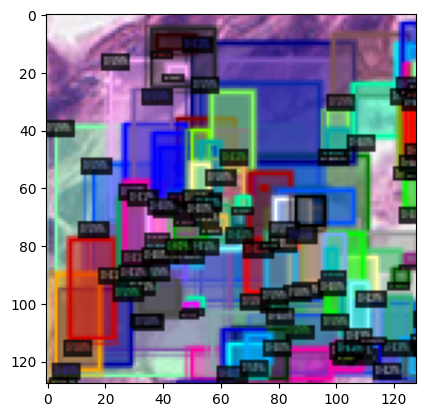

In [74]:
v = Visualizer(img)
v._default_font_size = 2
# v = v.draw_instance_predictions(outputs["instances"].to("cpu").__getitem__([2]))
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

## Inference on test dataset

In [44]:
# from detectron2.evaluation import DatasetEvaluator
# from detectron2.evaluation import inference_on_dataset

In [197]:
 #import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

directory = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/output/"

In [198]:
#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("nuclei_detection_test", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "nuclei_detection_test")

WARNING [01/19 23:52:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


FileNotFoundError: [Errno 2] No such file or directory: './output/nuclei_detection_test_coco_format.json'

In [47]:
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[01/19 22:32:37 d2.evaluation.evaluator]: Start inference on 115 batches
[01/19 22:32:39 d2.evaluation.evaluator]: Inference done 11/115. Dataloading: 0.0005 s/iter. Inference: 0.0825 s/iter. Eval: 0.0002 s/iter. Total: 0.0831 s/iter. ETA=0:00:08


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b9d095ab170>
Traceback (most recent call last):
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b9d095ab170>
Traceback (most recent call last):
  File "/dart

[01/19 22:32:44 d2.evaluation.evaluator]: Inference done 66/115. Dataloading: 0.0281 s/iter. Inference: 0.0619 s/iter. Eval: 0.0001 s/iter. Total: 0.0902 s/iter. ETA=0:00:04


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b9d095ab170>
Traceback (most recent call last):
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b9d095ab170>
Traceback (most recent call last):
  File "/dart

[01/19 22:32:48 d2.evaluation.evaluator]: Total inference time: 0:00:09.806048 (0.089146 s / iter per device, on 1 devices)
[01/19 22:32:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.060003 s / iter per device, on 1 devices)
[01/19 22:32:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/19 22:32:48 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/19 22:32:48 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/19 22:32:48 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/19 22:32:48 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[01/19 22:32:48 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[01/19 22:32:48 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP)

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan})])

In [32]:
!nvidia-smi

Tue Jan 17 23:14:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    51W / 300W |  11271MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   